In [1]:
import scanpy as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import glob
import anndata
import random
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE

import warnings
warnings.filterwarnings('ignore')

os.chdir('/u/home/s/skikuchi/scratch/BIOMATH206')

import decoupler as dc

scanpy==1.10.1 anndata==0.10.4 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.11


In [2]:
adata1 = sc.read_10x_mtx("/u/home/s/skikuchi/scratch/BIOMATH206/data/RB04")
adata1.obs['sample'] = "RB04"
adata1.obs['sex'] = 'male'

adata2 = sc.read_10x_mtx("/u/home/s/skikuchi/scratch/BIOMATH206/data/RB05")
adata2.obs['sample'] = "RB05"
adata2.obs['sex'] = 'female'

adata3 = sc.read_10x_mtx("/u/home/s/skikuchi/scratch/BIOMATH206/data/RB06")
adata3.obs['sample'] = "RB06"
adata3.obs['sex'] = 'male'

adata4 = sc.read_10x_mtx("/u/home/s/skikuchi/scratch/BIOMATH206/data/RB07")
adata4.obs['sample'] = "RB07"
adata4.obs['sex'] = 'female'

adata = anndata.concat([adata1, adata2, adata3, adata4], merge="same") 

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [13]:
adata = adata2

In [14]:
# set the observation names of mitocondrial genes, ribosomal genes, and hemoglobin genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
adata.var['rb'] = adata.var_names.str.startswith(("RPS","RPL"))
adata.var['Hb'] = adata.var_names.str.startswith(("HBA","HBB","HBQ")) 
#adata.var['pred'] = adata.var_names.str.startswith(("GM1", "GM2", "GM3", "GM4", "GM5", "GM6", "GM7", "GM8", "GM9"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['Hb'], percent_top=None, log1p=False, inplace=True)
#sc.pp.calculate_qc_metrics(adata, qc_vars=['pred'], percent_top=None, log1p=False, inplace=True)
adata

AnnData object with n_obs × n_vars = 13016 × 33538
    obs: 'sample', 'sex', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_Hb', 'pct_counts_Hb'
    var: 'gene_ids', 'feature_types', 'mt', 'rb', 'Hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [15]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 2 cells that have less than 200 genes expressed
filtered out 12969 genes that are detected in less than 3 cells


In [16]:
'''fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=(15, 20))
for ax, var in zip([ax1, ax2, ax3], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt']):
    ax = sc.pl.violin(adata, var, ax=ax, groupby='sample',show=False, stripplot=False, xlabel=' ') # show: set to False to use axes object, stripplot: set to False to hide dots
    ax.set_title(var)

fig.tight_layout()
fig.savefig('plots/prefilter_qcplot.png')'''

"fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=(15, 20))\nfor ax, var in zip([ax1, ax2, ax3], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt']):\n    ax = sc.pl.violin(adata, var, ax=ax, groupby='sample',show=False, stripplot=False, xlabel=' ') # show: set to False to use axes object, stripplot: set to False to hide dots\n    ax.set_title(var)\n\nfig.tight_layout()\nfig.savefig('plots/prefilter_qcplot.png')"

In [17]:
'''fig, [ax1, ax2, ax3, ax4] = plt.subplots(1,4, figsize=(15, 5))
ax1 = sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", ax=ax1, show=False)
ax2 = sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", ax=ax2, show=False)
ax3 = sc.pl.scatter(adata, x="total_counts", y="pct_counts_rb", ax=ax3, show=False)
ax4 = sc.pl.scatter(adata, x="total_counts", y="pct_counts_Hb", ax=ax4, show=False)
fig.tight_layout()'''

'fig, [ax1, ax2, ax3, ax4] = plt.subplots(1,4, figsize=(15, 5))\nax1 = sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", ax=ax1, show=False)\nax2 = sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", ax=ax2, show=False)\nax3 = sc.pl.scatter(adata, x="total_counts", y="pct_counts_rb", ax=ax3, show=False)\nax4 = sc.pl.scatter(adata, x="total_counts", y="pct_counts_Hb", ax=ax4, show=False)\nfig.tight_layout()'

In [18]:
adata = adata[adata.obs.total_counts < 30000, :]
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

In [19]:
import loompy as lp

In [20]:
adata.X

<12889x20569 sparse matrix of type '<class 'numpy.float32'>'
	with 31940455 stored elements in Compressed Sparse Column format>

In [22]:
adata.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
sys.getsizeof(adata.X.toarray())/1024/1024

1011.3291664123535

In [25]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
 # 直す
lp.create( '/u/home/s/skikuchi/scratch/BIOMATH206/data/filtered_RB05.loom', adata.X.transpose(), row_attrs, col_attrs)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


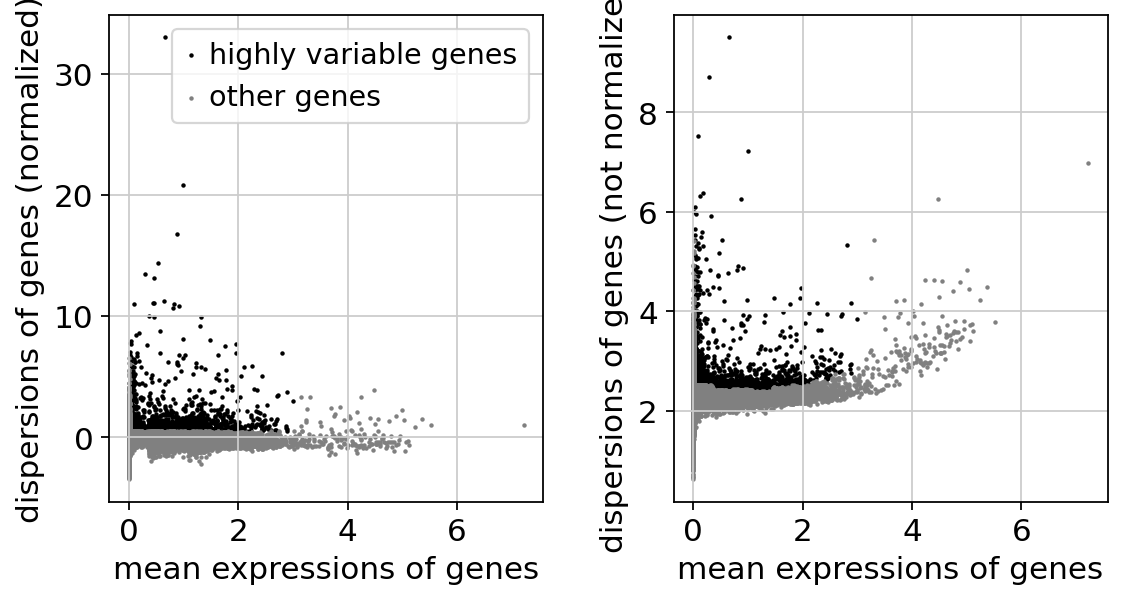

In [8]:
adata.layers['counts'] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=3e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [9]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']


    sparse input is densified and may lead to high memory use
    finished (0:01:49)


clustering, dim reduction, integration

computing PCA
    with n_comps=50


    finished (0:00:52)


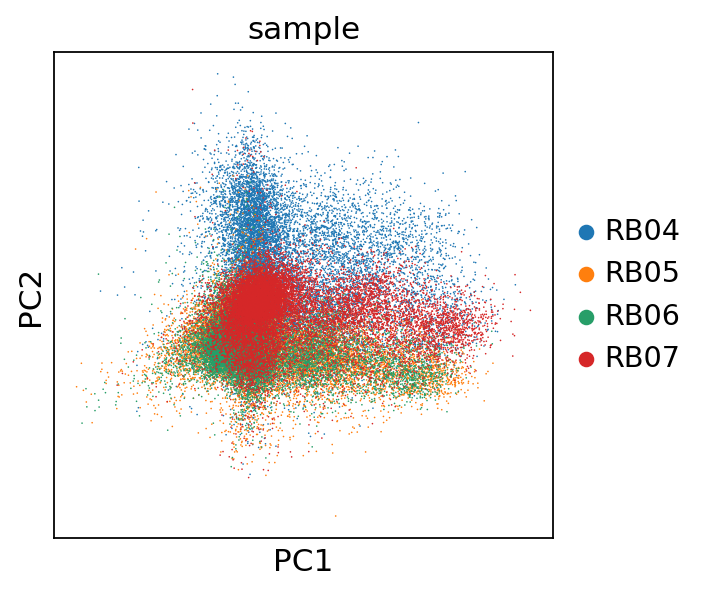

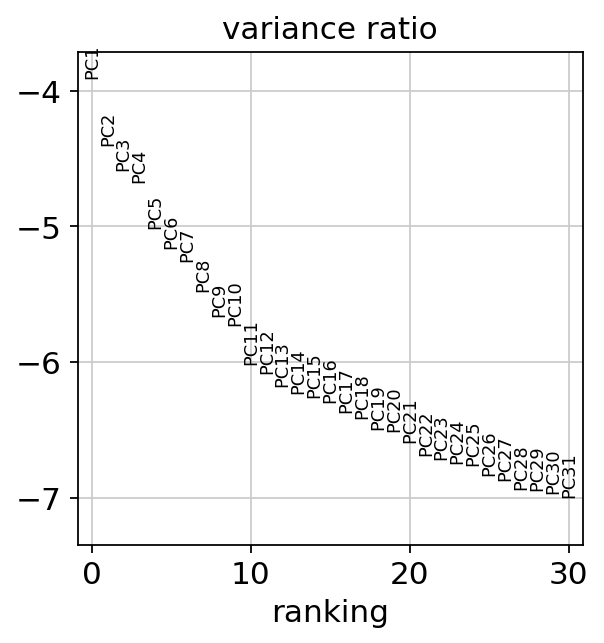

In [10]:
# PCA
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca(adata, color ="sample")
sc.pl.pca_variance_ratio(adata, log=True)

In [11]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:44)
running Leiden clustering
    finished: found 27 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:02)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:57)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:06)


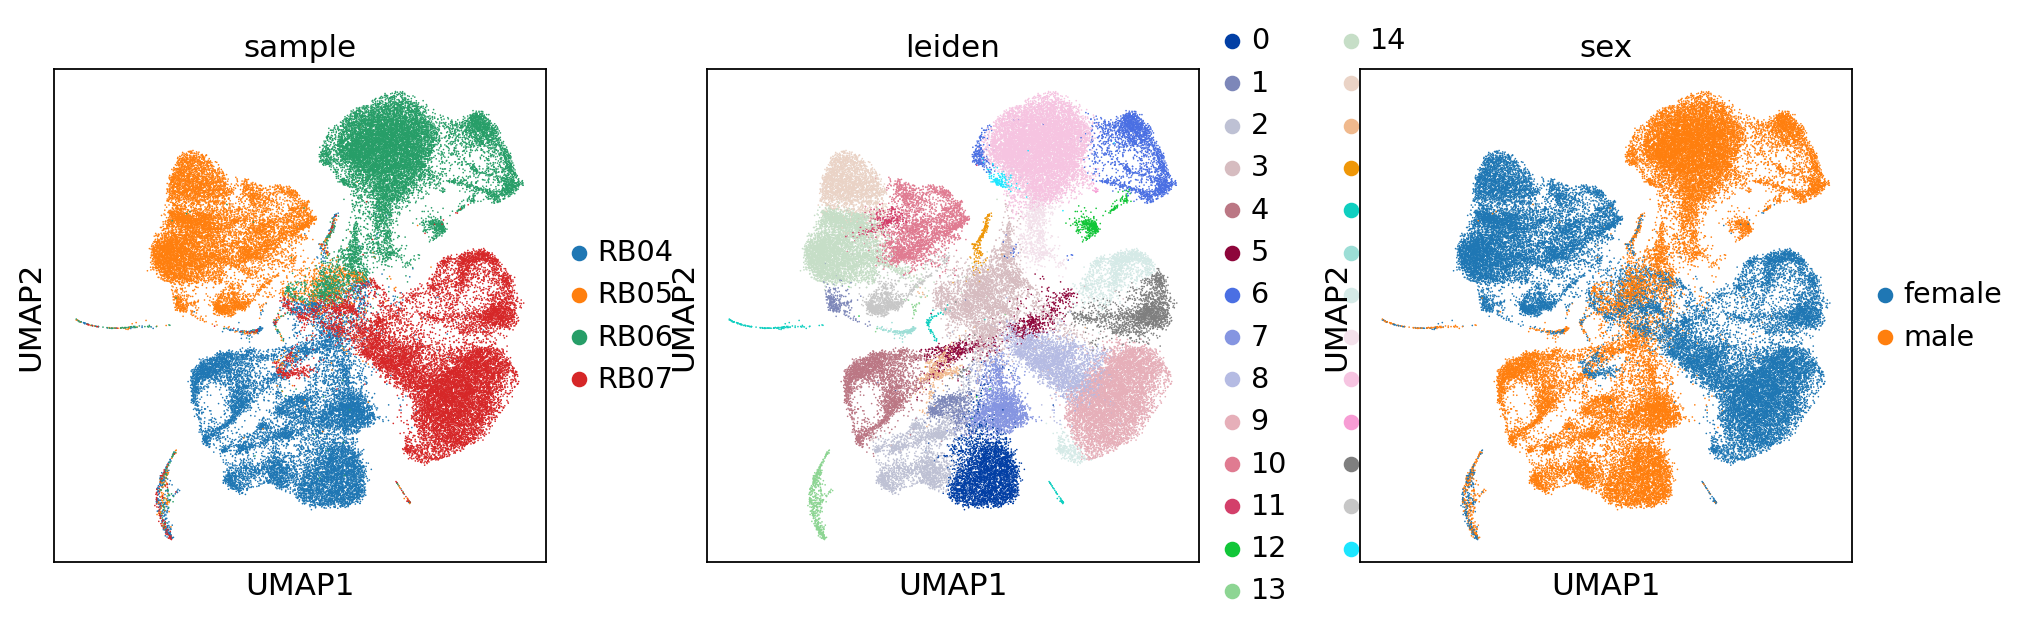

In [12]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
sc.tl.umap(adata)

sc.pl.umap(adata, color=["sample", "leiden", "sex"])

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:07)


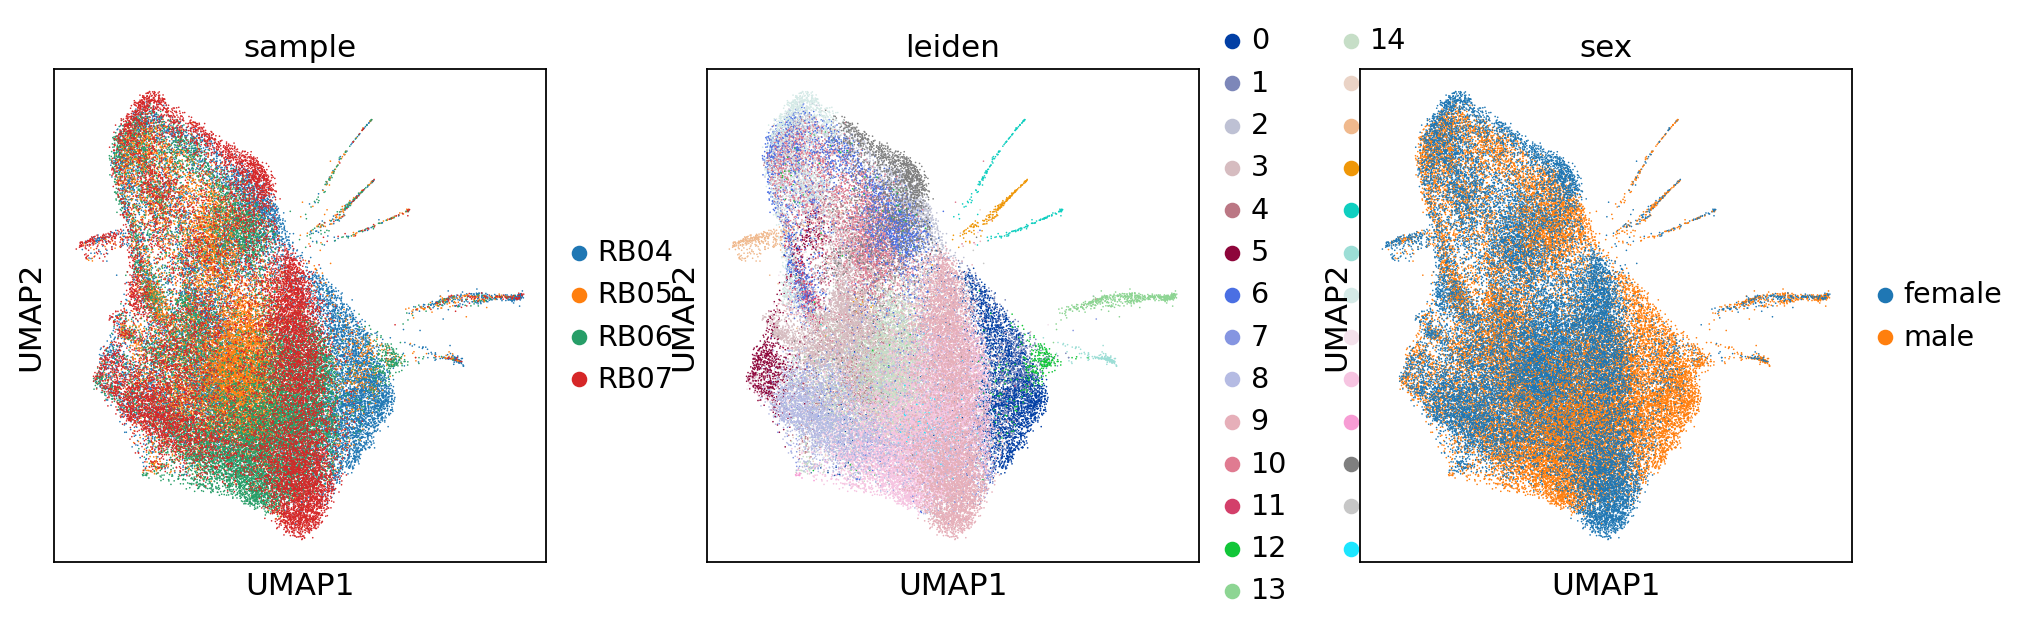

In [13]:
sc.external.pp.bbknn(adata, batch_key="sample")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["sample", "leiden", "sex"])
adata.write( 'processed_anndata_bbknn.h5ad' )

In [14]:
sc.external.pp.harmony_integrate(adata, key="sample")
sc.external.pp.harmony_integrate(adata, key="sample", basis='X_umap', adjusted_basis='X_umap_harmony')

2024-05-29 10:21:17,081 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-29 10:21:34,855 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-29 10:21:35,502 - harmonypy - INFO - Iteration 1 of 10
2024-05-29 10:22:01,385 - harmonypy - INFO - Iteration 2 of 10
2024-05-29 10:22:27,753 - harmonypy - INFO - Converged after 2 iterations
2024-05-29 10:22:27,796 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-29 10:22:30,965 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-29 10:22:31,507 - harmonypy - INFO - Iteration 1 of 10
2024-05-29 10:22:55,144 - harmonypy - INFO - Iteration 2 of 10
2024-05-29 10:23:18,900 - harmonypy - INFO - Converged after 2 iterations


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:02)


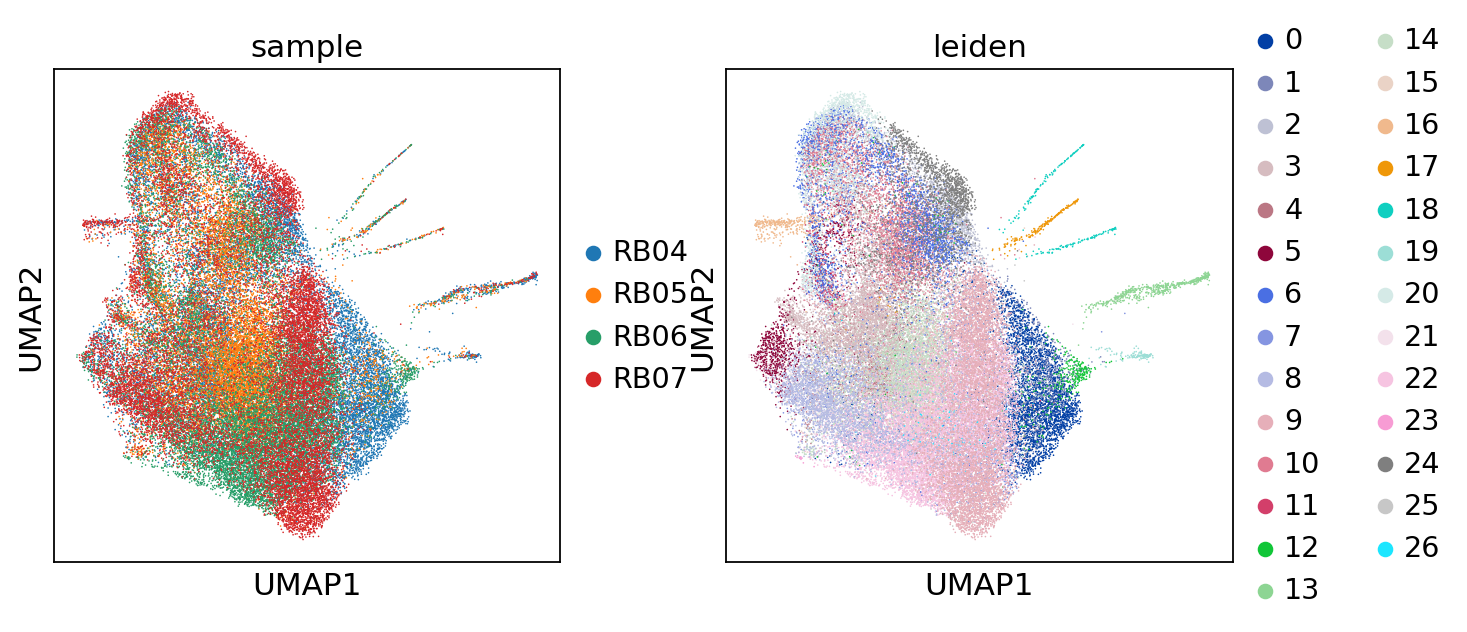

In [15]:
sc.tl.umap(adata, init_pos='X_umap_harmony')
sc.pl.umap(adata, color=["sample", "leiden"], layer='X_umap_harmony')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:19)


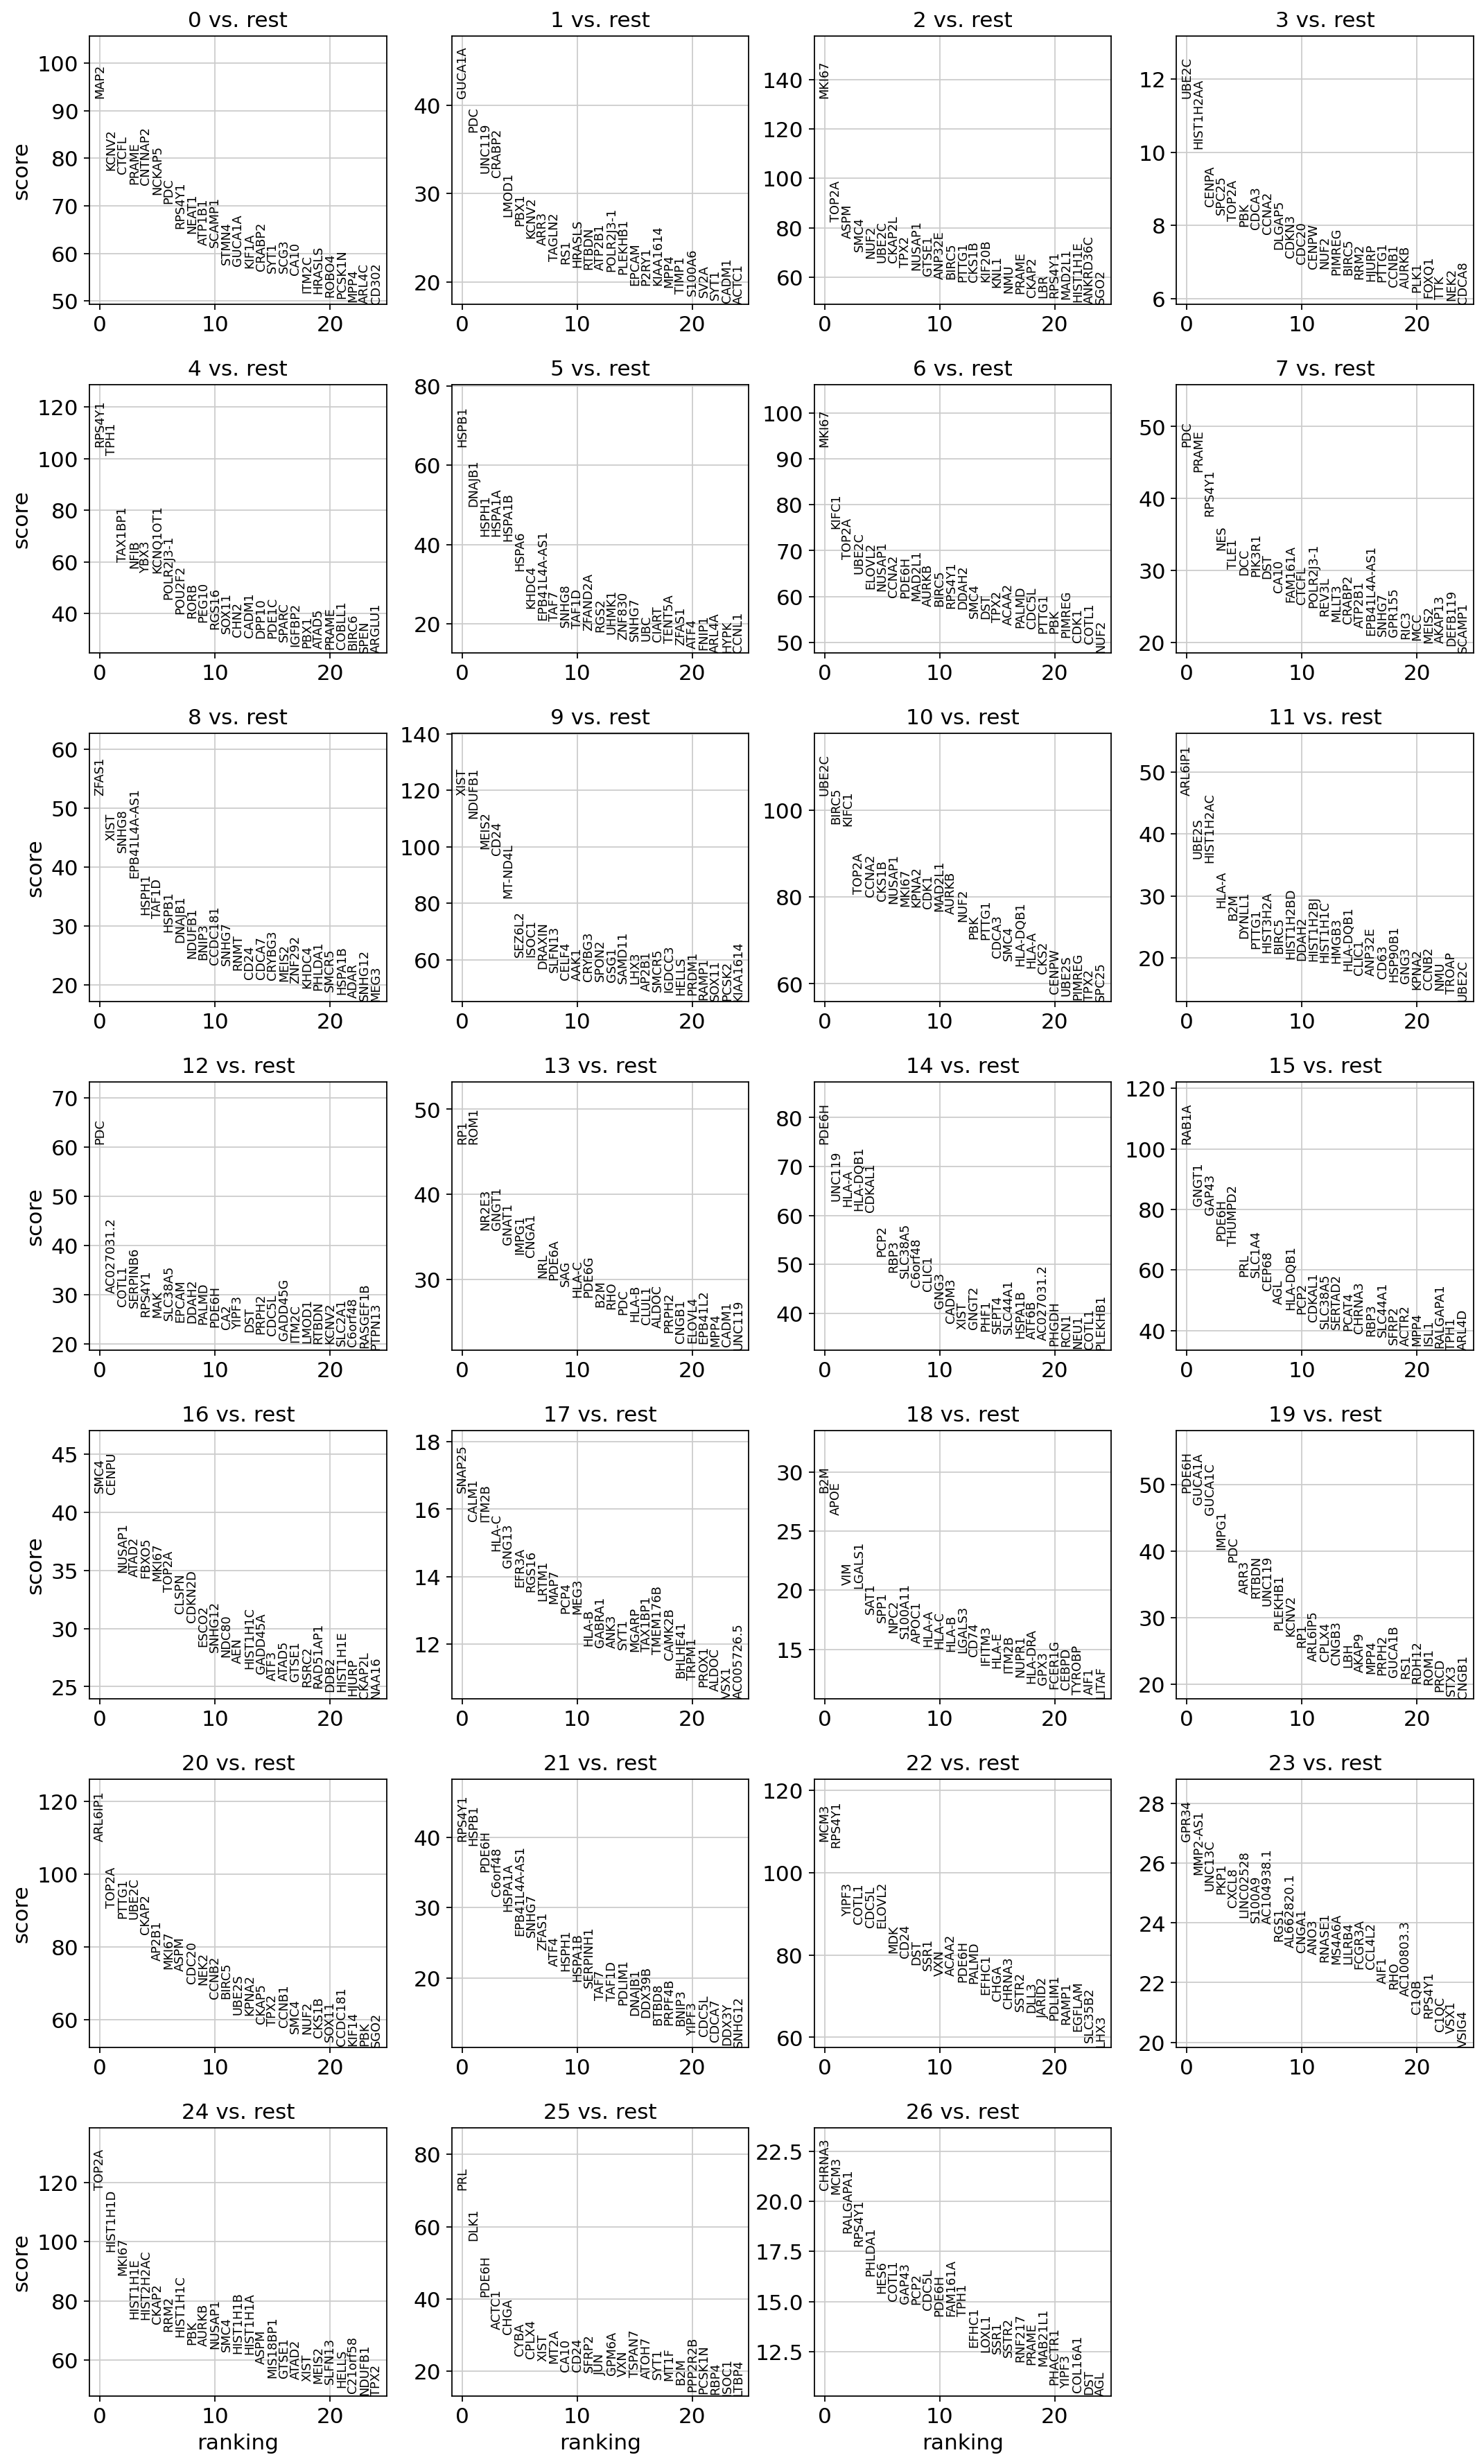

0       1       2          3          4             5       6  \
0     MAP2  GUCA1A   MKI67      UBE2C     RPS4Y1         HSPB1   MKI67   
1    KCNV2     PDC   TOP2A  HIST1H2AA       TPH1        DNAJB1   KIFC1   
2    CTCFL  UNC119    ASPM      CENPA    TAX1BP1         HSPH1   TOP2A   
3    PRAME  CRABP2    SMC4      SPC25       NFIB        HSPA1A   UBE2C   
4  CNTNAP2   LMOD1    NUF2      TOP2A       YBX3        HSPA1B  ELOVL2   
5   NCKAP5    PBX1   UBE2C        PBK   KCNQ1OT1         HSPA6  NUSAP1   
6      PDC   KCNV2  CKAP2L      CDCA3  POLR2J3-1         KHDC4   CCNA2   
7   RPS4Y1    ARR3    TPX2      CCNA2     POU2F2  EPB41L4A-AS1   PDE6H   
8    NEAT1  TAGLN2  NUSAP1     DLGAP5       RORB          TAF7  MAD2L1   
9   ATP1B1     RS1   GTSE1      CDKN3      PEG10         SNHG8   AURKB   

         7             8        9  ...      17       18       19       20  \
0      PDC         ZFAS1     XIST  ...  SNAP25      B2M    PDE6H  ARL6IP1   
1    PRAME          XIST   NDUFB1  ...   CALM1     APOE   GUCA1A    TOP2A   
2   RPS4Y1         SNHG8    MEIS2  ...   ITM2B      VIM   GUCA1C    PTTG1   
3      NES  EPB41L4A-AS1     CD24  ...   HLA-C   LGALS1    IMPG1    UBE2C   
4     TLE1         HSPH1  MT-ND4L  ...   GNG13     SAT1      PDC    CKAP2   
5      DCC         TAF1D   SEZ6L2  ...   EFR3A     SPP1     ARR3    AP2B1   
6   PIK3R1         HSPB1    ISOC1  ...   RGS16     NPC2    RTBDN    MKI67   
7      DST        DNAJB1   DRAXIN  ...   LRTM1  S100A11   UNC119     ASPM   
8     CA10        NDUFB1   SLFN13  ...    MAP7    APOC1  PLEKHB1    CDC20   
9  FAM161A         BNIP3    CELF4  ...    PCP4    HLA-A    KCNV2     NEK2   

             21      22          23         24     25        26  
0        RPS4Y1    MCM3       GPR34      TOP2A    PRL    CHRNA3  
1         HSPB1  RPS4Y1    MMP2-AS1   HIST1H1D   DLK1      MCM3  
2         PDE6H   YIPF3      UNC13C      MKI67  PDE6H  RALGAPA1  
3       C6orf48   COTL1        PKP1   HIST1H1E  ACTC1    RPS4Y1  
4        HSPA1A   CDC5L       CXCL8  HIST2H2AC   CHGA    PHLDA1  
5  EPB41L4A-AS1  ELOVL2   LINC02528      CKAP2   CYBA      HES6  
6         SNHG7     MDK      S100A9       RRM2  CPLX4     COTL1  
7         ZFAS1    CD24  AC104938.1   HIST1H1C   XIST     GAP43  
8          ATF4     DST        RGS1        PBK   MT2A      PCP2  
9         HSPH1    SSR1  AL662820.1      AURKB   CA10     CDC5L  

[10 rows x 27 columns]

In [16]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

In [24]:
import omnipath as op
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
markers

genesymbol  canonical_marker          cell_type germ_layer  human  \
0         CTRB1             False        Enterocytes   Endoderm   True   
1         CTRB1              True       Acinar cells   Endoderm   True   
2          KLK1              True  Endothelial cells   Mesoderm   True   
3          KLK1             False       Goblet cells   Endoderm   True   
4          KLK1             False   Epithelial cells   Mesoderm   True   
...         ...               ...                ...        ...    ...   
8456    SLC14A1              True   Urothelial cells   Mesoderm   True   
8457      UPK3A              True   Urothelial cells   Mesoderm   True   
8458      UPK1A              True   Urothelial cells   Mesoderm   True   
8459       UPK2              True   Urothelial cells   Mesoderm   True   
8460      UPK3B              True   Urothelial cells   Mesoderm   True   

      human_sensitivity  human_specificity  mouse  mouse_sensitivity  \
0              0.000000           0.004394   True           0.003311   
1              1.000000           0.000629   True           0.957143   
2              0.000000           0.008420   True           0.000000   
3              0.588235           0.005039   True           0.903226   
4              0.000000           0.008233   True           0.225806   
...                 ...                ...    ...                ...   
8456           0.000000           0.018170   True           0.000000   
8457           0.000000           0.000000   True           0.000000   
8458           0.000000           0.000000   True           0.000000   
8459           0.000000           0.000000   True           0.000000   
8460           0.000000           0.000000   True           0.000000   

      mouse_specificity  ncbi_tax_id            organ  ubiquitiousness  
0              0.020480         9606         GI tract            0.017  
1              0.015920         9606         Pancreas            0.017  
2              0.014915         9606      Vasculature            0.013  
3              0.012408         9606         GI tract            0.013  
4              0.013758         9606       Epithelium            0.013  
...                 ...          ...              ...              ...  
8456           0.000000         9606  Urinary bladder            0.008  
8457           0.000000         9606  Urinary bladder            0.000  
8458           0.000000         9606  Urinary bladder            0.000  
8459           0.000000         9606  Urinary bladder            0.000  
8460           0.000000         9606  Urinary bladder            0.000  

[8461 rows x 13 columns]

In [28]:
marker = sorted(markers['cell_type'].unique())
for i in marker:
    print(i)

Acinar cells
Adipocyte progenitor cells
Adipocytes
Adrenergic neurons
Airway epithelial cells
Airway goblet cells
Airway smooth muscle cells
Alpha cells
Alveolar macrophages
Anterior pituitary gland cells
Astrocytes
B cells
B cells memory
B cells naive
Basal cells
Basophils
Bergmann glia
Beta cells
Cajal-Retzius cells
Cardiac stem and precursor cells
Cardiomyocytes
Cholangiocytes
Cholinergic neurons
Chondrocytes
Choroid plexus cells
Chromaffin cells
Ciliated cells
Clara cells
Crypt cells
Decidual cells
Delta cells
Dendritic cells
Distal tubule cells
Dopaminergic neurons
Ductal cells
Embryonic stem cells
Endothelial cells
Endothelial cells (aorta)
Endothelial cells (blood brain barrier)
Enteric glia cells
Enteric neurons
Enterochromaffin cells
Enterocytes
Enteroendocrine cells
Eosinophils
Ependymal cells
Epiblast cells
Epithelial cells
Epsilon cells
Erythroblasts
Erythroid-like and erythroid precursor cells
Fibroblasts
Follicular cells
Foveolar cells
GABAergic neurons
Gamma (PP) cells
G

In [22]:
marker = markers[markers['human'] & markers['canonical_marker']]
for i in marker.organ.unique():
    print(i)

Pancreas
Vasculature
Kidney
Immune system
GI tract
Connective tissue
Mammary gland
Lungs
Skin
Epithelium
Liver
Blood
Brain
Bone
Skeletal muscle
Reproductive
Thymus
Eye
Smooth muscle
Heart
Parathyroid glands
<NA>
Adrenal glands
Zygote
Embryo
Urinary bladder
Thyroid
Olfactory system


In [23]:
organ_li = ['Eye', 'Connective tissue', 'Blood']
for i in marker[marker['organ'].isin(organ_li)].cell_type.unique():
    print(i)
marker = marker[marker['organ'].isin(organ_li)]

Fibroblasts
Platelets
Adipocytes
Adipocyte progenitor cells
Chondrocytes
Müller cells
Stromal cells
Erythroblasts
Retinal progenitor cells
Reticulocytes
Erythroid-like and erythroid precursor cells
Photoreceptor cells
